In [1]:
from sklearn.model_selection import train_test_split
from data_loader import DataLoader
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
X_train_full, y_train_full = DataLoader.load_batch('data_batch')
X_test, y_test = DataLoader.load_batch('test_batch', Nbatches=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.15)

Randomly sample `num` images from the arguments, if `y_pred` is provided indicate both the predicted and the actual class name on the image.

In [2]:
from random import sample
from numpy import ndarray
from matplotlib import pyplot as plt
def display_randomly_sampled_images(num: int, X: ndarray, y_true: ndarray, y_pred: ndarray = None):
	plt.figure(figsize=(num, 5))
	for i, j in enumerate(sample(range(len(X)), num)):
		plt.subplot(1, num, i + 1)
		plt.imshow(X[j])
		plt.axis('off')
		plt.tight_layout(pad=5 / num)
		prediction = ''
		if y_pred is not None:
			prediction += '\nPredicted:\n'
			prediction += class_names[y_pred[j]]
		plt.title(class_names[y_true[j]] + prediction)
	plt.show()

Training Set


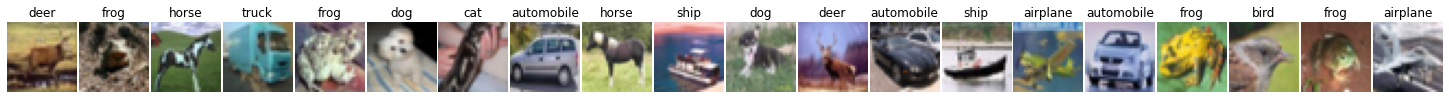

Validation Set


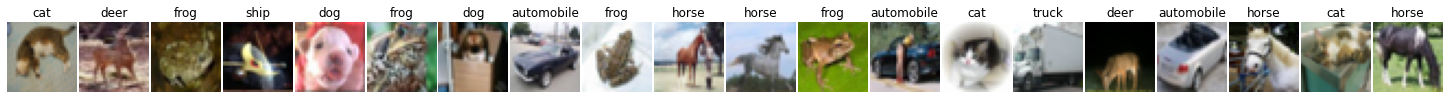

Test Set


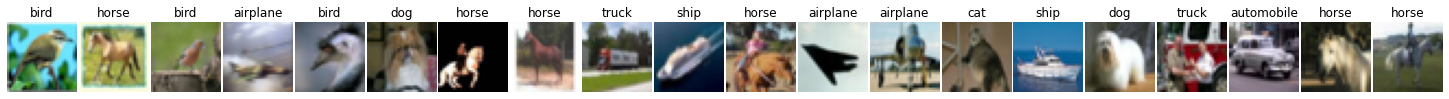

In [3]:
print('Training Set')
display_randomly_sampled_images(20, X_train, y_train)
print('Validation Set')
display_randomly_sampled_images(20, X_val, y_val)
print('Test Set')
display_randomly_sampled_images(20, X_test, y_test)

Define a function that takes in a `Sequential` model and a learning rate scheduler, returns a record of training and validation loss values and metrics values at successive epochs from the `History` object as well as the compiled and trained model using the learning rate scheduler and early stopping with `patience` equals to 10 and `restore_best_weights` set to `True`, so that when the performance no longer improves after `patience` number of epochs training will stop and restore weights from the best epoch in that set.

The model has been compiled with `sgd` as the optimizer and `sparse_categorical_crossentropy` as the loss function. `sgd` is stochastic gradient descent optimizer with `momentum` but by default it is set to 0, so there is no `momentum` optimization involved, it is just the basic `sgd` where the gradients are computed at every step based on a random instance being picked.

There are 10 classes in this dataset so it is a multi-class classification problem, therefore `crossentropy` loss function is required. Furthermore since the labels are provided as integers instead of the `one-hot` representation, `sparse` is required instead of just `categorical_crossentropy`.

In [4]:
from tensorflow.keras import models, layers, callbacks
from typing import Callable
LearningRateScheduler = Callable[[int, float], float]
def train_model(model: models.Sequential, learning_rate_scheduler: LearningRateScheduler):
	learning_rate_scheduler_cb = callbacks.LearningRateScheduler(learning_rate_scheduler)
	early_stopping_cb = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
	model.compile('sgd', 'sparse_categorical_crossentropy', 'accuracy')
	history = model.fit(
		X_train,
		y_train,
		epochs=100,
		validation_data=(X_val, y_val),
		callbacks=[early_stopping_cb, learning_rate_scheduler_cb],
		batch_size=128,
		verbose=0
	)
	return history.history, model

Create a MPL that is parameterised by connection weight initialiser, learning rate scheduler and dropout rate. There is a `Dropout` layer after every `Dense` layer to add regularisation.

In [5]:
def mlp(kernel_initializer: str, learning_rate_scheduler: LearningRateScheduler, dropout_rate: float):
	return train_model(models.Sequential([
		layers.Flatten(input_shape=X_train.shape[1:], name="input"),
		layers.Dense(1000, activation='relu', name="dense_1", kernel_initializer=kernel_initializer),
		layers.Dropout(dropout_rate, name='dropout_1'),
		layers.Dense(500, activation='relu', name="dense_2", kernel_initializer=kernel_initializer),
		layers.Dropout(dropout_rate, name='dropout_2'),
		layers.Dense(100, activation='relu', name="dense_3", kernel_initializer=kernel_initializer),
		layers.Dropout(dropout_rate, name='dropout_3'),
		layers.Dense(len(class_names), activation='softmax', name="output")
	], name='MLP'), learning_rate_scheduler)

Use nested for loops to fine tune 3 hyperparameters, this function takes in 3 lists of hyperparameters and returns a dictionary of chosen hyperparameters to the model.

In [6]:
def grid_search(hyperparameters1, hyperparameters2, hyperparameters3, model: Callable):
	models = {}
	for i in hyperparameters1:
		for j in hyperparameters2:
			for k in hyperparameters3:
				key = f'{i} {j.__name__ if isinstance(j, Callable) else j} {k}'
				models[key] = model(i, j, k)
	return models

Call `grid_search` to get all the models using different hyperparameters. Save the best one based on the maximum `val_accuracy` in the `History` object output from `Model.fit` which is also saved to a `gridsearch.p` pickle file.

In [7]:
import pickle
NAME = 'Liang_Kaiqi'
def save_best_model(hyperparameters1, hyperparameters2, hyperparameters3, model: Callable):
	folder = f'{NAME}-{model.__name__.upper()}'
	grid_search_res = grid_search(hyperparameters1, hyperparameters2, hyperparameters3, model)

	best_params, (history, best_model) = max(grid_search_res.items(), key=lambda x: max(x[1][0]['val_accuracy']))
	best_model.save(folder)

	with open(f'{folder}/gridsearch.p', 'wb') as fp:
		pickle.dump({best_params: history}, fp)
	return best_model

Define a learning rate scheduler that only starts dropping after 10 epochs for CNN as I find that if the learning rate decreases too quickly early stopping won't happen and the CNN will train for the entire 100 epochs because when the learning rate is too small we run into the vanishing gradients problem.

In [8]:
import math
def scheduler(epoch: int, lr: float) -> float:
	if epoch < 10:
		return lr
	else:
		return lr * math.exp(-0.1)

Create a CNN that is parameterised by kernel size, number of kernels and activation function, these only apply to the first convolutional layer, except for the number of kernels on the second convolutional layer is twice the first one because we want the image to get smaller but deeper as it progresses through the network, and the pooling layer between is shinking the image size. Use the default kernel initialiser, 0.5 dropout rate.

In [9]:
def cnn(kernel_size: int, num_of_kernels: int, activation: str):
	return train_model(models.Sequential([
		layers.Conv2D(
			num_of_kernels,
			kernel_size,
			activation=activation,
			padding='same',
			input_shape=X_train.shape[1:],
			name='input'
		),
		layers.MaxPool2D(name='max_pooling_1'),
		layers.Conv2D(
			num_of_kernels * 2,
			3,
			activation='relu',
			padding='same',
			name='convolution'
		),
		layers.MaxPool2D(name='max_pooling_2'),
		layers.Flatten(name='flattern'),
		layers.BatchNormalization(name='batch_normalisation'),
		layers.Dense(100, activation='relu', name='dense'),
		layers.Dropout(0.5, name='dropout'),
		layers.Dense(len(class_names), activation='softmax', name='output')
	], name='CNN'), scheduler)


Open the pickle file that stores the grid search results of the training and validation loss and accuracy for all the hyperparameter tuning and show the learning curve plot.

In [10]:
import pandas as pd
def learning_curve_plot(df: pd.DataFrame):
	plt.figure(figsize=(3, 10))
	plt.subplot(311)
	plt.title('loss')
	df[['loss', 'val_loss']].plot(ax=plt.gca())

	plt.subplot(312)
	plt.title('accuracy')
	df[['accuracy', 'val_accuracy']].plot(ax=plt.gca())

	plt.subplot(313)
	plt.title('learning rate')
	df['lr'].plot(ax=plt.gca())


Load the saved model and time it for training 1 epoch by setting `initial_epoch` to the number of epochs it has been trained for and `epochs` to be `initial_epoch + 1`. Then to make sure the learning rate used is correct pass in the same learning rate scheduler that was used to train the previous epochs.

Estimate the overall computation time by multiplying the time it takes to train 1 epoch by the number of epochs.

In [11]:
import time
def load_best_model(model_name: str, learning_rate_scheduler: LearningRateScheduler = scheduler):
	folder = f'{NAME}-{model_name}'
	with open(f'{folder}/gridsearch.p', 'rb') as fp:
		history = pickle.load(fp)
		[(best_params, values)] = history.items()
		[param1, param2, param3] = best_params.split()

		if param2 == 'power':
			learning_rate_scheduler = power
		elif param2 == 'exponential':
			learning_rate_scheduler = exponential

		df = pd.DataFrame(values)
		epochs = len(df)

		model = models.load_model(f'{folder}')
		start = time.time()
		learning_rate_scheduler_cb = callbacks.LearningRateScheduler(learning_rate_scheduler)
		model.fit(
			X_train,
			y_train,
			callbacks=[learning_rate_scheduler_cb],
			initial_epoch=epochs,
			epochs=epochs + 1
		)
		end = time.time()

		time_per_epoch = end - start
		computation_time = epochs * time_per_epoch

		print(f'\nTime it takes to train for 1 epoch: {round(time_per_epoch, 2)} seconds')
		print(f'Number of epochs: {epochs}')
		print(f'Approximate computation time to train the model with the best hyperparameters: {round(computation_time, 2)} seconds')
		print(f'\nBest parameters for {model_name}')

		learning_curve_plot(df)
		return model, param1, param2, param3

Check if the directories of the saved models exist, if not grid search for the best hyperparamesters and save the best models. Otherwise load the models and train for 1 epoch and visualise the learing curve plot for each grid search model.

In [12]:
from os import path, environ
import tensorflow as tf
# Disable tensorflow warning messages
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
# Disable tensorflow error messages
environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

The hyperparameters picked for grid search MLP are `he_normal` and `he_uniform` for connection weight initialisation, `power` and `exponential` for learning rate scheduling, 0.1 and 0.5 for dropout rate.

Connection weight initialisation is a technique to initialisethe connection weights between neurons randomly. He initialisation is chosen because it works well with the `ReLU` activation function which is used in MLP.

`he_normal` uses the normal distribution with mean 0 and variance $$\sigma^2=\frac{2}{fan_{avg}}$$

`he_uniform` uses a uniform distribution over the interval [-r, +r] with $$r=\sqrt{2}\sqrt{\frac{3}{fan_{avg}}}$$

Learning rate scheduling gradually reduces the learning rate to allow the algorithm to settle to the global minimum. Power scheduling and Exponential scheduling are some commonly used learning schedules which are implemented below.

In [13]:
def power(epoch: int, lr0: float) -> float:
	return lr0 / (1 + epoch / 5)

def exponential(epoch: int, lr0: float) -> float:
	return lr0 * 0.1 ** (epoch / 5)

These 2 schedulers have the same hyperparameter `step` set to 5, `exponential` reduces the learning rate faster than `power` during training where the initial learning rate `lr0` drops by a factor of 10 every 5 steps. A comparision is illustrated by the plot blow.

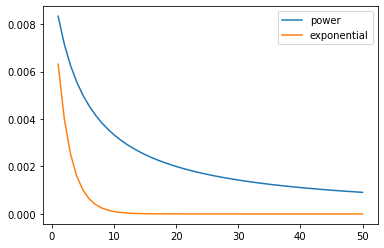

In [14]:
import numpy as np
x = np.linspace(1, 50)
plt.plot(x, power(x, 0.01), label='power')
plt.plot(x, exponential(x, 0.01), label='exponential')
plt.legend()
plt.show()

`Dropout` is one of the most popular regularisation techniques for DNNs, and dropout rate is a hyperparameter which is typically set to 50% so 0.1 and 0.5 are chosen for the grid search.

Epoch 26/26
1329/1329 [==============================] - 7s 5ms/step - loss: 1.7086 - accuracy: 0.3967 - lr: 1.3483e-15

Time it takes to train for 1 epoch: 6.72 seconds
Number of epochs: 25
Approximate computation time to train the model with the best hyperparameters: 168.01 seconds

Best parameters for MLP
kernel initializer: he_uniform
learning rate scheduler: power
dropout rate: 0.1


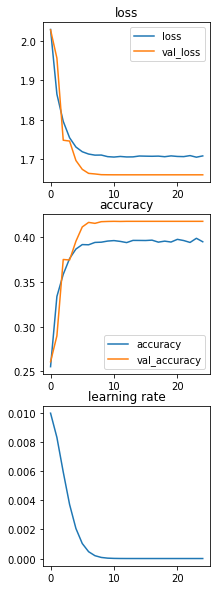

In [15]:
mlp_model: models.Sequential = None
if path.isdir(f'{NAME}-MLP'):
	mlp_model, kernel_initializer, learning_rate_scheduler, dropout_rate = load_best_model('MLP')
	print(f'kernel initializer: {kernel_initializer}')
	print(f'learning rate scheduler: {learning_rate_scheduler}')
	print(f'dropout rate: {dropout_rate}')
else:
	mlp_model = save_best_model(
		['he_normal', 'he_uniform'],
		[power, exponential],
		[0.1, 0.5],
		mlp
	)

From the MLP learning curve plot the `accuracy` on the training set and `val_accuracy` are quite similar however `val_accuracy` is slightly higher which is a result of `Dropout` since the behaviour when training and testing are different. With 0.1 dropout rate at each training step every neuron has a 10% chances of being ignored but during testing neurons don't get dropped anymore, resulting a better accuracy for testing which is a good thing about incorporating `Dropout`.

It only trained for 25 epochs before `EarlyStopping` kicked in and it only took 7 seconds to train 1 epoch making it 3 minutes (almost 180 seconds) to train the entire model.

The hyperparameters that produced the MLP model with the highest accuracy are `he_uniform` weight initialiser, power scheduling and 0.1 dropout rate. Meaning that for this particular dataset of images using uniform distribution to randomise initial weights performs better than normal distribution, exponential scheduling might be dropping the learning rate too rapidly and power is about right, having a 50% chance for every neuron to be dropped out might be too high even though it is what typically being used and 10% is more gentle.

----------------------------------------------------------

The hyperparameters picked for grid search CNN are 5 and 7 for kernel size, 32 and 64 for number of kernels, `relu` and `selu` for activation function.

Kernel size defines how big the convolution filter is, usually the first convolutional layer will have a large kernel either 5 x 5 or 7 x 7, and the rest will be kept at 3 x 3 because it will use fewer parameters and usually perform better.

Number of kernels determines the number of feature maps and the number of channels the output layer has.

Activation function defines the output of a neuron given an input or set of inputs. Each CNN layer generally is followed by a `ReLU` layer, so it is chosen for the grid search along with one of its variants `SELU` which is a scaled version and it has the self-normalisation property, i.e. preservering the mean and variance of each alyer's output during training so it is the recommended activation function to use in general.

Epoch 93/93
1329/1329 [==============================] - 28s 21ms/step - loss: 0.7266 - accuracy: 0.7488 - lr: 2.4852e-06

Time it takes to train for 1 epoch: 28.43 seconds
Number of epochs: 92
Approximate computation time to train the model with the best hyperparameters: 2615.95 seconds

Best parameters for CNN
kernel size: 5
number of kernels: 64
activation function: relu


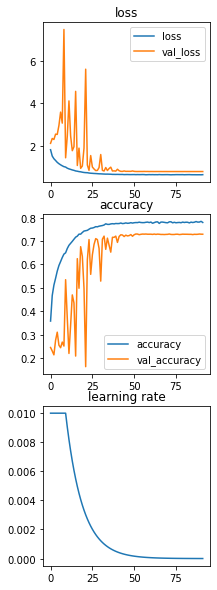

In [16]:
cnn_model: models.Sequential = None
if path.isdir(f'{NAME}-CNN'):
	cnn_model, kernel_size, num_kernels, activation_function = load_best_model('CNN')
	print(f'kernel size: {kernel_size}')
	print(f'number of kernels: {num_kernels}')
	print(f'activation function: {activation_function}')
else:
	cnn_model = save_best_model(
		[5, 7],
		[32, 64],
		['relu', 'selu'],
		cnn
	)

From the CNN learning curve plot the `accuracy` on the training set is 80% but `val_accuracy` is only 73% which seems to be an overfitting issue that MPL didn't have.

It trained for 93 epochs where each epoch took about 28 seconds giving it over 43 minutes (more than 2600 seconds) of overall computation time which is roughly 15 times longer than MLP took.

The CNN model with the highest accuracy from the grid search results has 64 5 x 5 kernels in the first convolutional layer followed by a `ReLU` activation layer and 128 3 x 3 kernels in the second convolutional layer also with `ReLu`.

In [17]:
mlp_model.summary()

Model: "MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Flatten)             (None, 3072)              0         
                                                                 
 dense_1 (Dense)             (None, 1000)              3073000   
                                                                 
 dropout_1 (Dropout)         (None, 1000)              0         
                                                                 
 dense_2 (Dense)             (None, 500)               500500    
                                                                 
 dropout_2 (Dropout)         (None, 500)               0         
                                                                 
 dense_3 (Dense)             (None, 100)               50100     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0       

A `Dense` layer is fully connected so the number of parameters for that layer is the number of neurons including the extra bias neuron multiplied by the number of output neurons from the last layer. The total number of parameters is the sum of the all the parameters from every `Dense` layer and all of them are trainable parameters.

In [18]:
cnn_model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Conv2D)              (None, 32, 32, 64)        4864      
                                                                 
 max_pooling_1 (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 convolution (Conv2D)        (None, 16, 16, 128)       73856     
                                                                 
 max_pooling_2 (MaxPooling2D  (None, 8, 8, 128)        0         
 )                                                               
                                                                 
 flattern (Flatten)          (None, 8192)              0         
                                                                 
 batch_normalisation (BatchN  (None, 8192)             32768   

A `Conv2D` layer has much fewer parameters compared to a `Dense` layer as it is calculated by the size of the kernel multiplied by the number of input channels plus 1 then times by the the number of kernels.

Since the CNN needs fully connected layers before the output layer to classify the images after learning all the features through the convolutional layers the majority number of parameters actually come from the `Dense` layers rather than the `Conv2D` layers.

A `BatchNormalization` layer introduces 4 parameters $\gamma$, $\beta$, $\mu$ and $\sigma$ so the number of parameters for that is 4 times the number of output neurons from the layer above. The first 2 are trainable and the other 2 are not which is why half of the parameters in the `BatchNormalization` layer are non-trainable parameters.

In [19]:
from sklearn import metrics
def confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray, title: str):
	metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=class_names)
	fig = plt.gcf()
	fig.set_size_inches(8, 8)
	fig.suptitle(title)
	plt.xticks(rotation=90)
	plt.show()

Display classification report including precision and F1 score per class, and the overall accuracy, the confusion matrices on both the training and test sets as well as 5 correctly classified and failure cases for the test set.

Since the output layer outputs 10 neurons representing the probabilities of each class it is not sufficient to do predictions, which is why `argmax` is used to produce the final classification result by picking the highest probability as the output class.

In [20]:
def report(model: models.Sequential):
	y_pred = np.argmax(model.predict(X_test), axis=-1)
	print(metrics.classification_report(y_test, y_pred, target_names=class_names))

	confusion_matrix(y_train, np.argmax(model.predict(X_train), axis=-1), 'Training Set')
	confusion_matrix(y_test, y_pred, 'Test Set')

	correct = np.where(np.equal(y_pred, y_test) == True)[0]
	failure = np.where(np.equal(y_pred, y_test) == False)[0]

	display_randomly_sampled_images(5, X_test[correct], y_test[correct], y_pred[correct])
	display_randomly_sampled_images(5, X_test[failure], y_test[failure], y_pred[failure])

MLP has an accuracy of 42%, it misclassified a large number of cats as dogs, automobiles as trucks and airplanes as ships which are challenging tasks as they all look quite similar to each other.

              precision    recall  f1-score   support

    airplane       0.49      0.49      0.49      1000
  automobile       0.47      0.48      0.48      1000
        bird       0.31      0.25      0.28      1000
         cat       0.33      0.20      0.25      1000
        deer       0.37      0.35      0.36      1000
         dog       0.34      0.35      0.34      1000
        frog       0.41      0.49      0.45      1000
       horse       0.44      0.45      0.45      1000
        ship       0.50      0.60      0.55      1000
       truck       0.46      0.51      0.49      1000

    accuracy                           0.42     10000
   macro avg       0.41      0.42      0.41     10000
weighted avg       0.41      0.42      0.41     10000



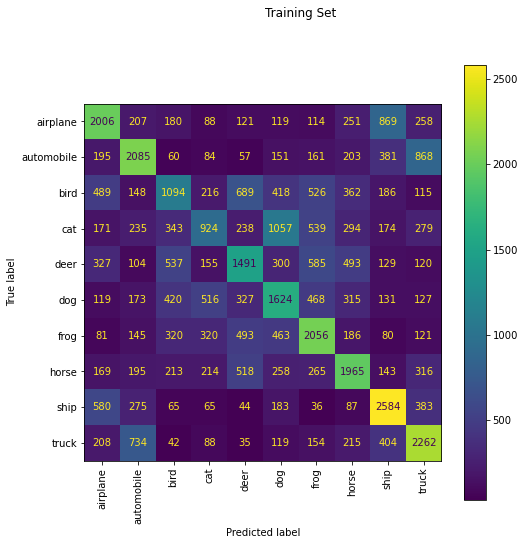

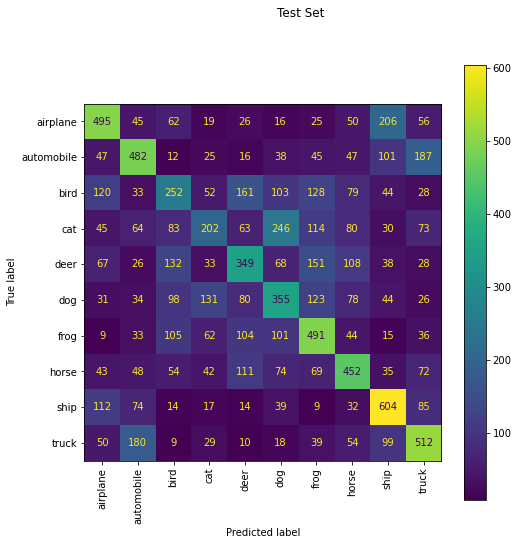

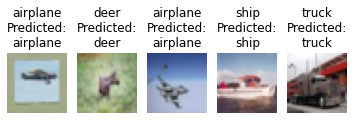

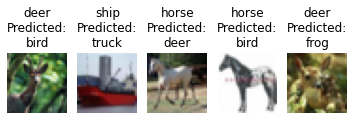

In [21]:
report(mlp_model)

CNN has an accuracy of 73%, dogs and cats are the only pair that stands out in the confusion matrix being misclassified as each other. It did quite well on automobiles and airplanes and compared to MLP it still reduced a large number of false positives and false negatives on dogs and cats which is a huge improvement.

              precision    recall  f1-score   support

    airplane       0.75      0.77      0.76      1000
  automobile       0.84      0.82      0.83      1000
        bird       0.62      0.58      0.60      1000
         cat       0.55      0.53      0.54      1000
        deer       0.70      0.68      0.69      1000
         dog       0.62      0.66      0.64      1000
        frog       0.76      0.81      0.79      1000
       horse       0.81      0.78      0.79      1000
        ship       0.82      0.83      0.83      1000
       truck       0.79      0.82      0.80      1000

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000



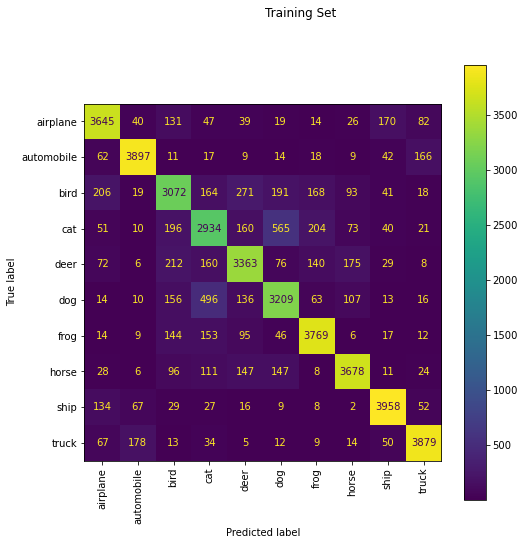

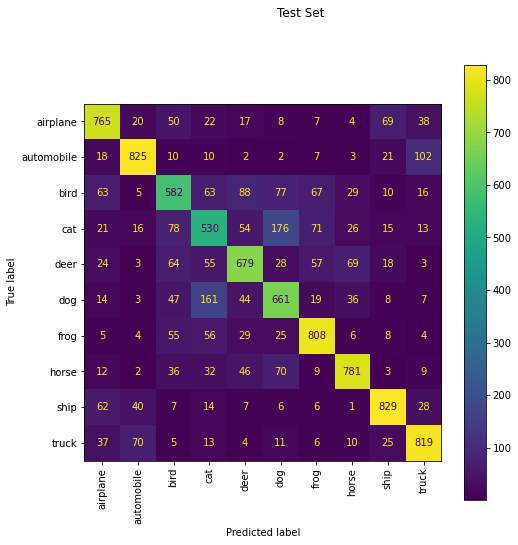

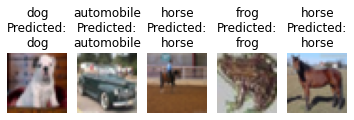

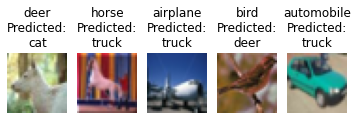

In [22]:
report(cnn_model)

Clearly CNN performs much better than MLP, which is why CNN is more commonly used in computer vision as it generally works better with images. As its convolutional layers allow it to learn features that MLP cannot that it is able to tackle challenging image classification tasks as shown in the results. However with the cost of computation time, even though there are much few trainable parameters in CNN, almost 1 million compared to MLP that had over 3.5 million parameters, it still took a magnitude longer than it took MLP to train.